# Modeling BLS signal from a single magnetic layer using the reciprocity theorem

This example shows how SpinWaveToolkit (SWT) can be used to calculate the BLS signal using the reciprocity theorem.

Source paper: https://doi.org/10.1126/sciadv.ady8833

### 1. Import modules and define parameters

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import SpinWaveToolkit as SWT
from scipy.ndimage import map_coordinates

In [28]:
# Define parameters
Bext = 50e-3         # External field [T]
theta = np.pi / 2    # Out-of-plane angle (fixed)
d_layer = 30e-9     # Magnetic layer thickness [m]
material = SWT.NiFe  # Material
Nf_common = 101     # Number of frequency points for Bloch function

NA=0.75           # Numerical Aperture (NA) for the lens

# Define the Kx,Ky grid limits and resolution.
k_min = 1e-6         # minimum k (avoid zero if necessary)
k_max = 20e6        # maximum k (as in original kxi range)
dk = 0.2e6
Nk = round((k_max-k_min)/dk)             # resolution in Kx and Ky

# Frequency range for Bloch functions
fmin, fmax = 1e9, 35e9  # Hz, frequency range for Bloch functions

### 2. Prepare the electric fields

Now, the electric fields need to be calculated. Ei corresponds to the driving field (incident laser) and the Ej to the virtual source. In accordance with our BLS detection scheme, they are calculated with orthogonal polarizations. They can either be obtained from SWT or numerically (FDTD).

To generate the field from SWT, the ObjectiveLens class can be used. To rotate the polarization, you can use the rotate_field() helper function.

In [29]:
print("Preparing focal field...")
objective = SWT.bls.ObjectiveLens(NA=NA, wavelength=532e-9, f0=10, f=1e-3)
xi, yi, Ex, Ey, Ez = objective.getFocalField(z=0, rho_max=10e-6, N=400)
Ei_fields = [Ex, Ey, Ez] 
Ej_fields = SWT.helpers.rotate_field(Ei_fields, xi, yi, 90) # Field with rotated polarization

Preparing focal field...


### 3. Calculate the dynamic susceptibility

In [30]:
print("Preparing dynamic susceptibility tensor...")

# Setup k-space grid 
kx_grid = np.linspace(-k_max, k_max, Nk)
ky_grid = np.linspace(-k_max, k_max, Nk)
KX, KY = np.meshgrid(kx_grid, ky_grid, indexing="ij")

# k-magnitude and propagation angle
phi0 = np.pi / 2
kxi = np.sqrt(KX**2 + KY**2)
phi = SWT.wrapAngle(np.arctan2(KY, KX) + phi0)
phi[kxi <= 1e-12] = 0.0  # avoid undefined angle at k=0

# Flatten for vectorized evaluation
kxi_fl = kxi.flatten()
phi_fl = phi.flatten()

# Allocate Bloch function storage
Bloch2D = np.zeros((Nf_common, Nk, Nk), dtype=complex)
w_common = np.linspace(2 * np.pi * fmin, 2 * np.pi * fmax, Nf_common)  # common frequency axis

# ...
# Create a SingleLayer model for the current kxi and phi.
# Note: We pass kxi and phi as flattened arrays of same shape.
model = SWT.SingleLayer(Bext=Bext, kxi=kxi_fl, theta=theta, 
                        phi=phi_fl, d=d_layer, material=material)
# Compute the Bloch functions for n=0,1,2.
# The returned w has shape (Nf_common,) and bf has shape (Nf_common, len(kxi))
w0, bf0 = model.GetBlochFunction(n=0, Nf=Nf_common)
w1, bf1 = model.GetBlochFunction(n=1, Nf=Nf_common)
# reshape Bloch functions to match the Kx,Ky grid shape
bf0 = bf0.reshape((Nf_common, Nk, Nk))
bf1 = bf1.reshape((Nf_common, Nk, Nk))
# Loop over all grid points in the Kx,Ky plane.
for i in range(Nk):
    for j in range(Nk):
        # Interpolate the Bloch functions to the common frequency axis.
        bf0_interp = np.interp(w_common, w0, bf0[:, i, j], left=0, right=0)
        bf1_interp = np.interp(w_common, w1, bf1[:, i, j], left=0, right=0)

        # Sum Bloch functions for n=0,1,2
        Bloch2D[:, i, j] = bf0_interp + bf1_interp

# Build susceptibility tensor χ
chi = np.zeros((3, 3, Nf_common, Nk, Nk), dtype=complex)

mx = Bloch2D
my = np.zeros_like(Bloch2D)
mz = Bloch2D * -1j

chi[0, 1] = 1j * mz
chi[1, 0] = -1j * mz
chi[1, 2] = 1j * mx
chi[2, 1] = -1j * mx

Preparing dynamic susceptibility tensor...


### 4. Calculate the BLS signal

In [31]:
print("Calculating BLS signal...")
# Using the optimized einsum-based function
sigmaSW, qmEiEj = SWT.bls.getBLSsignal_RT(
    Exy=(xi, yi), 
    Ei_fields=Ei_fields, 
    Ej_fields=Ej_fields, 
    KxKyChi=(kx_grid, ky_grid), 
    Chi=chi, 
    coherent_exc=False
)

Calculating BLS signal...


### 5. Visualize the results

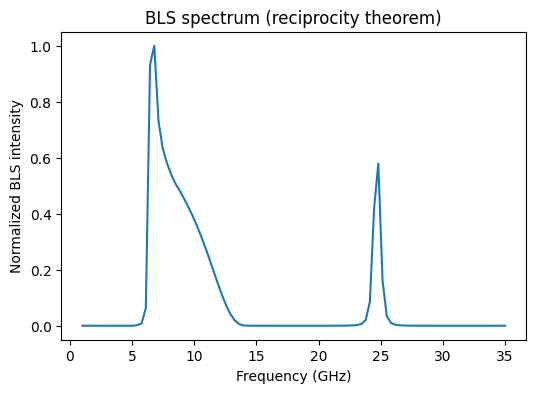

In [32]:
plt.figure(figsize=(6,4))
plt.plot(w_common/2/np.pi/1e9, sigmaSW / np.max(sigmaSW))
plt.xlabel("Frequency (GHz)")
plt.ylabel("Normalized BLS intensity")
plt.title("BLS spectrum (reciprocity theorem)")
plt.show()

### (6.) Visualize the dynamic susceptibility and the transfer function 

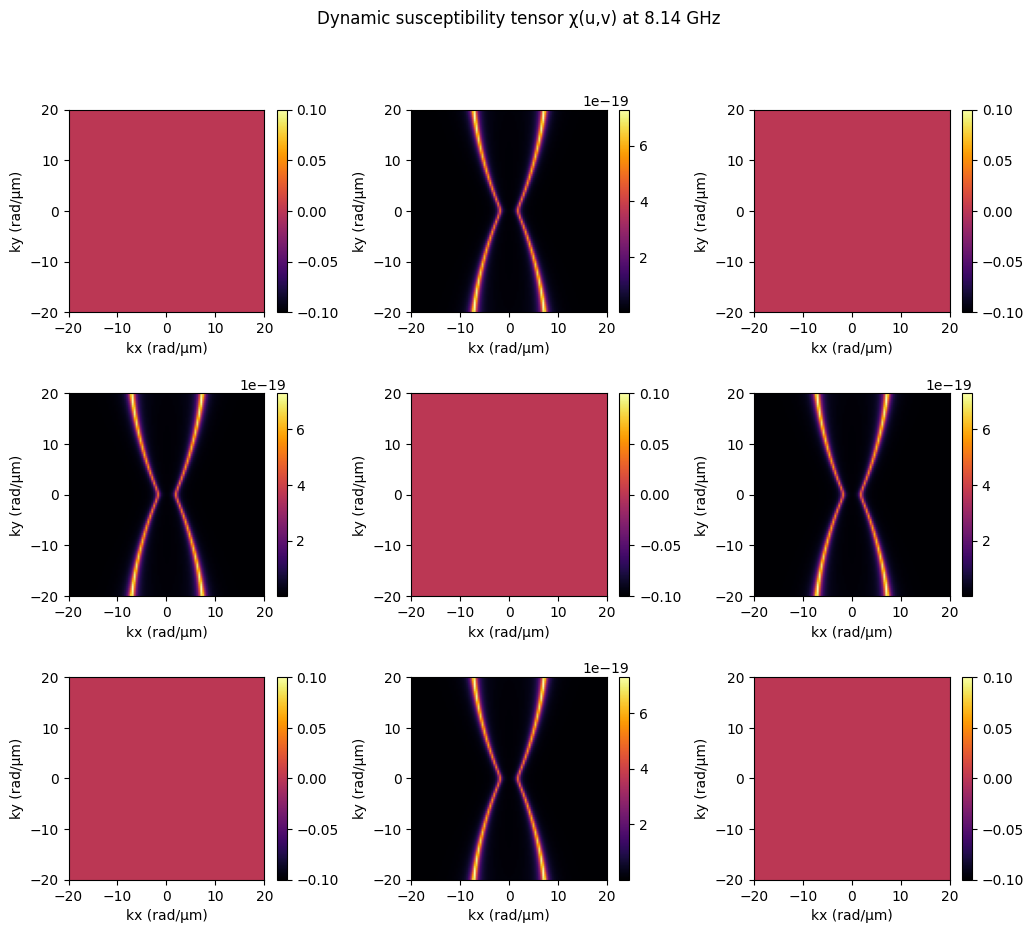

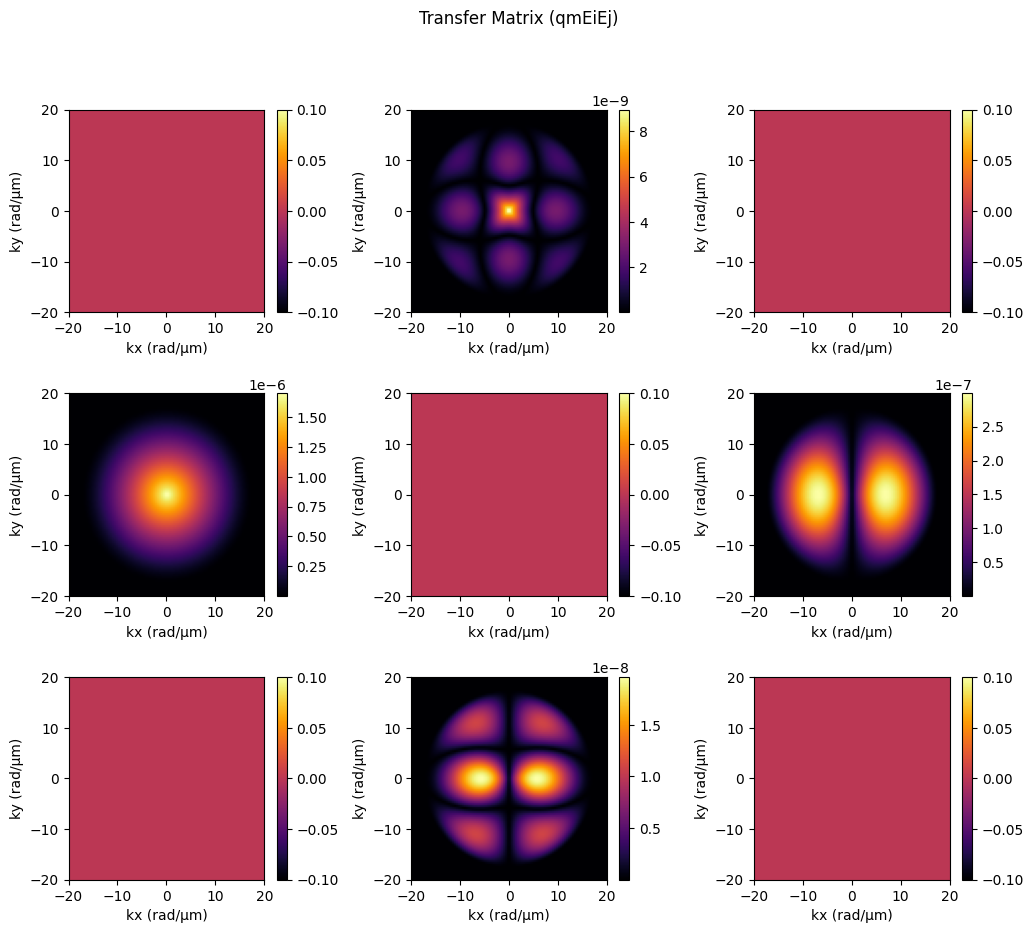

In [33]:
# Choose frequency to visualize 
f_desired = 8 # GHz, change this to any frequency you want

# Find the closest index in w_common
f_idx = np.argmin(np.abs(w_common/(2*np.pi*1e9) - f_desired))
f_plot = w_common[f_idx] / (2*np.pi*1e9)

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for u in range(3):
    for v in range(3):
        ax = axes[u, v]
        im = ax.imshow(
            np.abs(chi[u, v, f_idx, :, :]).T,
            extent=(kx_grid[0]*1e-6, kx_grid[-1]*1e-6,
                    ky_grid[0]*1e-6, ky_grid[-1]*1e-6),
            origin='lower', aspect='auto', cmap='inferno'
        )
        fig.colorbar(im, ax=ax)
        ax.set_xlabel("kx (rad/µm)")
        ax.set_ylabel("ky (rad/µm)")

plt.suptitle(f"Dynamic susceptibility tensor χ(u,v) at {f_plot:.2f} GHz")
plt.show()

# Plot qmEiEj matrix
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for u in range(3):
    for v in range(3):
        ax = axes[u, v]
        im = ax.imshow(
            np.abs(qmEiEj[u, v]).T,
            extent=(kx_grid[0]*1e-6, kx_grid[-1]*1e-6,
                    ky_grid[0]*1e-6, ky_grid[-1]*1e-6),
            origin='lower', aspect='auto', cmap='inferno'
        )
        fig.colorbar(im, ax=ax)
        ax.set_xlabel("kx (rad/µm)")
        ax.set_ylabel("ky (rad/µm)")

plt.suptitle("Transfer Matrix (qmEiEj)")
plt.show()